In [1]:
#prototype w
# Copyright 2023, Battelle Energy Alliance, LLC
import restWrapper #Custom class
import os
import matplotlib.pyplot as plt
from textwrap import wrap

In [2]:
HOST = 'localhost'
PORT = '2480'
USER = 'root'
PASS = 't3$t' # toor
DB = 'test' # winBulkTest
SAVEPLOTS = True # Change this to false to not save jpegs
OUTDIR = '.'

In [3]:
#Connect to database
client = restWrapper.RestAPIWrapper(HOST, PORT, USER, PASS, DB)
client.connectToDb()
#Check if database exists
if client.checkDbExists():
   print('database exists')
else:
    print('Database does not exist! This notebook assumes that you have a working OrientDB database with data loaded into it')
    sys.exit(0)
    

database exists


In [4]:
#Starting specific queries 
mostCommonAttackPatterns = client.query('select *, in().size() as size from attackpattern order by size desc', 10)
mostModifiedFiles = client.query('select *, in("modifies").size() as size from file order by size desc', 10)
mostDeletedFiles = client.query('select *, in("deletes").size() as size from file order by size desc', 10)
mostReadFiles = client.query('select *, in("reads").size() as size from file order by size desc', 10)

# More Ideas: 
#     Malware that creates the most network traffic 
#     Most used process 
#     Highest Malware analysis scores on a certain engine 
#     Common locations 
#     Shared domains or network traffic 
#     Malware related to people/groups with the same identity

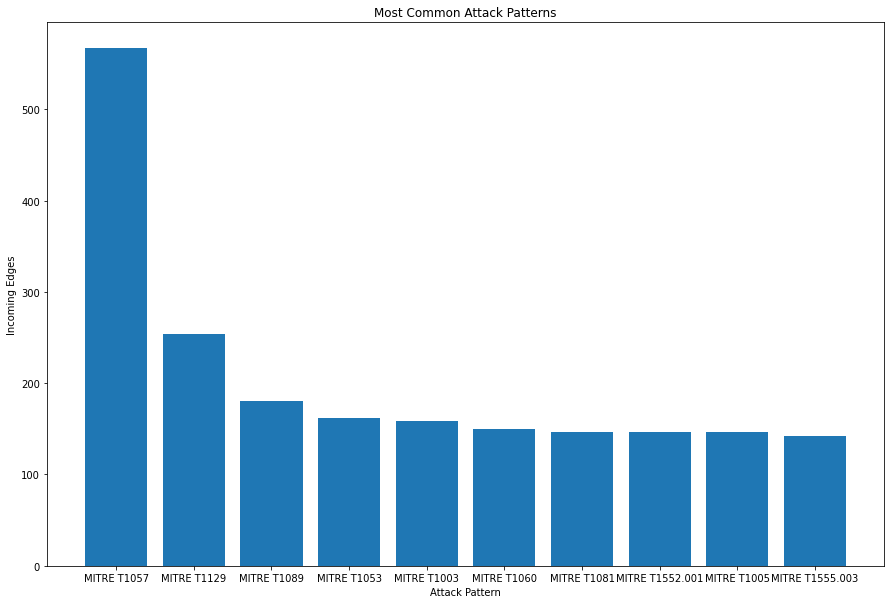

In [5]:
apList = []
numEdges = []

for ap in mostCommonAttackPatterns['result']:
    apList.append(f'MITRE {ap["external_references"][0]["external_id"]}')
    numEdges.append(len(ap['in_uses']))

plt.figure(figsize=(15,10))
plt.bar(apList, numEdges)
plt.title('Most Common Attack Patterns')
plt.xlabel('Attack Pattern')
plt.ylabel('Incoming Edges')
if SAVEPLOTS:
    plt.savefig(os.path.join(OUTDIR, "attackPatterns.jpg"))
plt.show()

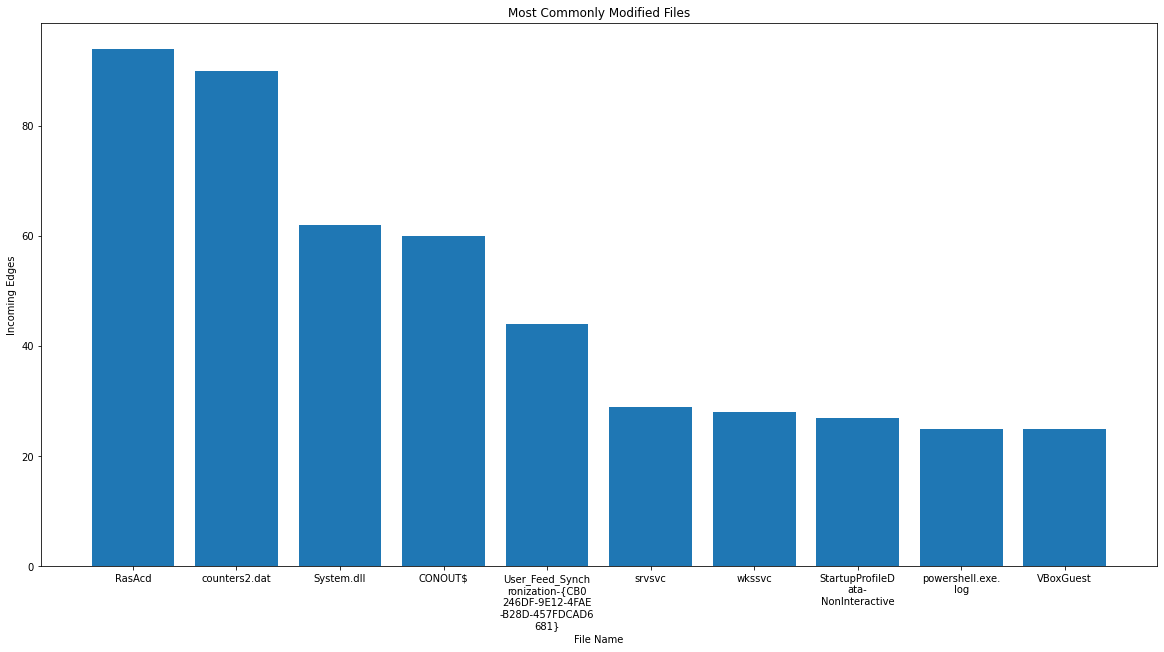

In [6]:
fileList = []
numEdges = []

for file in mostModifiedFiles['result']:
    fileList.append(file['name'])
    numEdges.append(len(file['in_modifies']))

fileList = ['\n'.join(wrap(l,15)) for l in fileList]
plt.figure(figsize=(20,10))
plt.bar(fileList, numEdges)
plt.title('Most Commonly Modified Files')
plt.xlabel('File Name')
plt.ylabel('Incoming Edges')
if SAVEPLOTS:
    plt.savefig(os.path.join(OUTDIR, "modifiedFiles.jpg"))
plt.show()


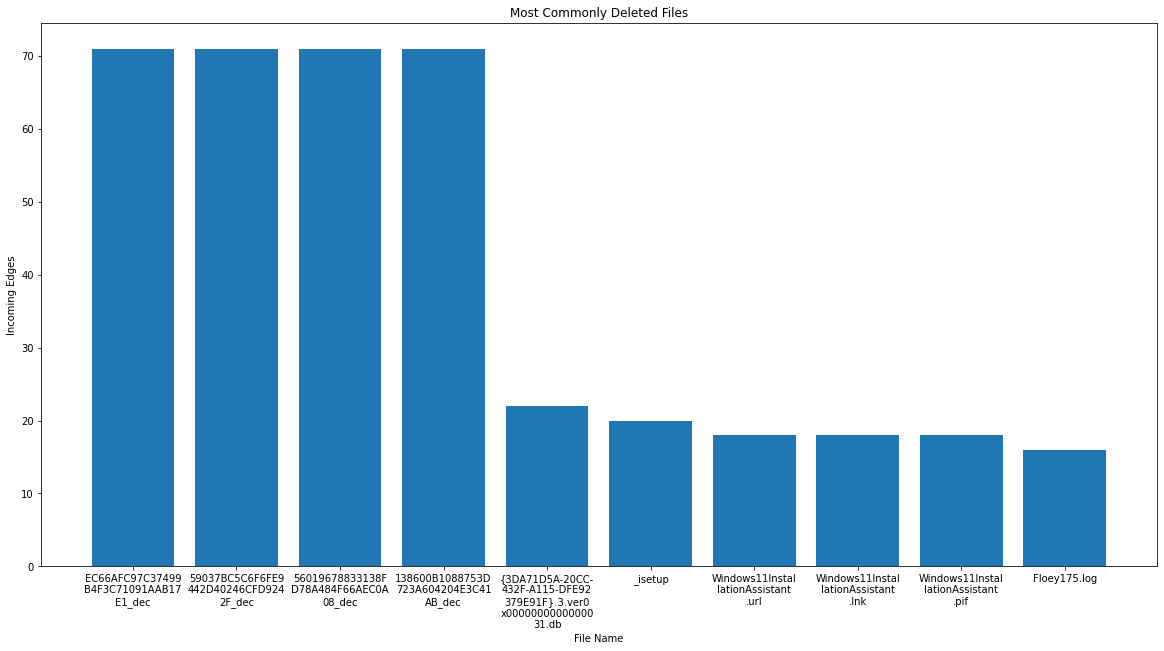

In [7]:
fileList = []
numEdges = []

for file in mostDeletedFiles['result']:
    fileList.append(file['name'])
    numEdges.append(len(file['in_deletes']))

fileList = ['\n'.join(wrap(l,15)) for l in fileList]
plt.figure(figsize=(20,10))
plt.bar(fileList, numEdges)
plt.title('Most Commonly Deleted Files')
plt.xlabel('File Name')
plt.ylabel('Incoming Edges')
if SAVEPLOTS:
    plt.savefig(os.path.join(OUTDIR, "deletedFiles.jpg"))

plt.show()

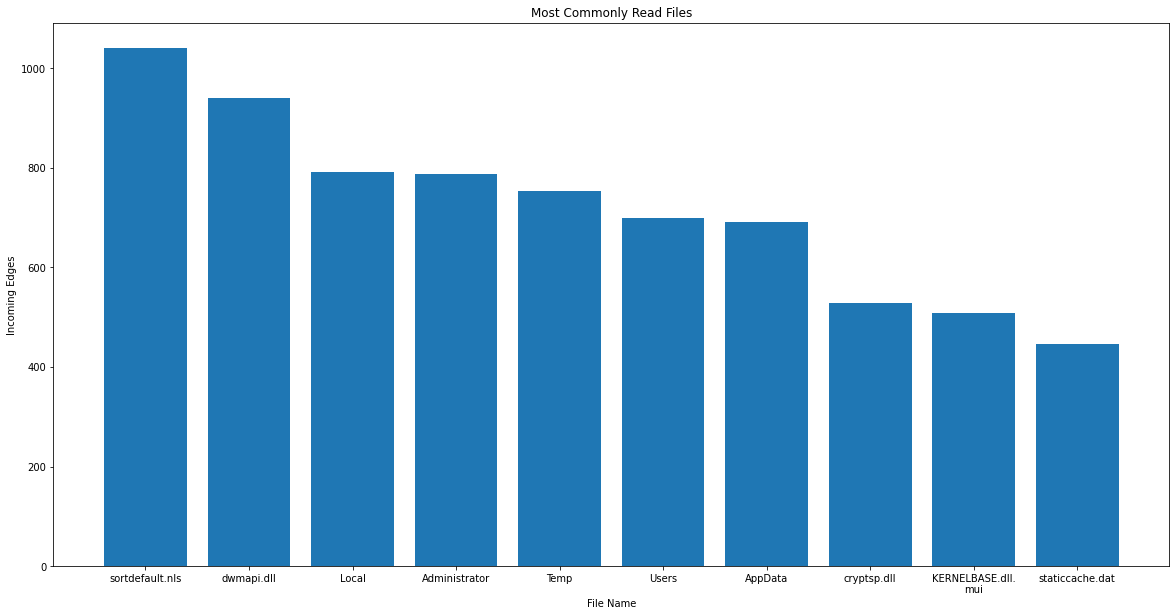

In [8]:
fileList = []
numEdges = []

for file in mostReadFiles['result']:
    fileList.append(file['name'])
    numEdges.append(len(file['in_reads']))

fileList = ['\n'.join(wrap(l,15)) for l in fileList]
plt.figure(figsize=(20,10))
plt.bar(fileList, numEdges)
plt.title('Most Commonly Read Files')
plt.xlabel('File Name')
plt.ylabel('Incoming Edges')
if SAVEPLOTS:
    plt.savefig(os.path.join(OUTDIR, "readFiles.jpg"))
plt.show()

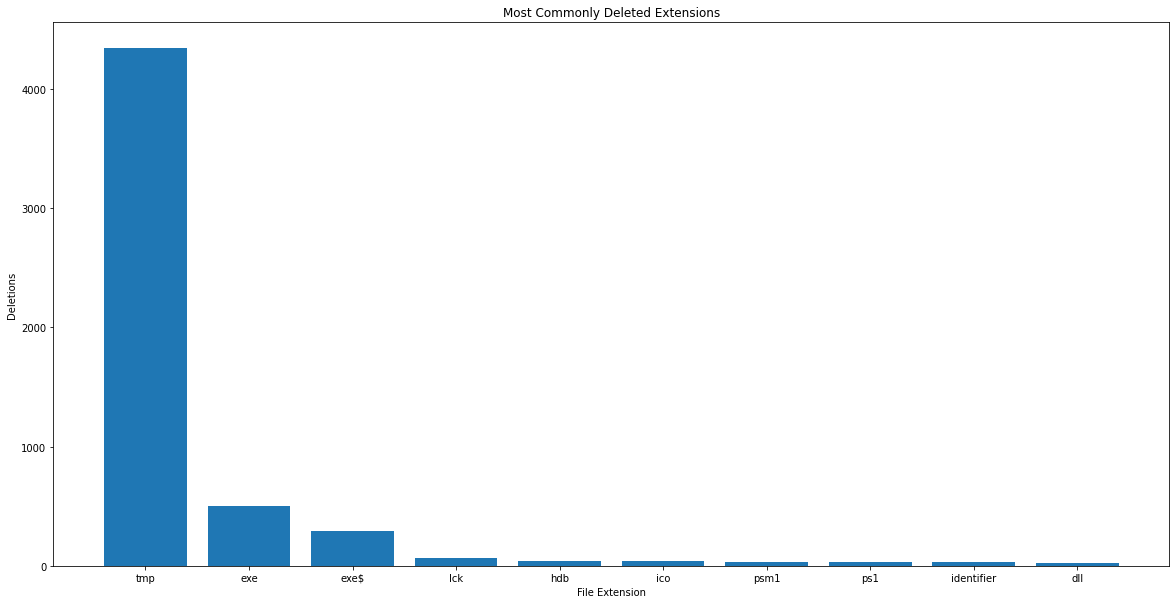

In [24]:
suffixList = []
deletions = []

# load function to db through command
client.command('sql', None,
               'create function rev "return str.split('').reverse().join('');" parameters [str] language javascript')

mostDeletedByExtension = client.query('select count(*) as instance, name.toLowerCase().right(rev(name).indexOf(".")) as suffix from(traverse out("deletes") from malware maxdepth 1) where @class = "file" and name.indexOf(".") > -1 group by name.toLowerCase().right(rev(name).indexOf(".")) order by instance desc', 10)

for suffix in mostDeletedByExtension['result']:
    deletions.append(suffix['suffix'])
    suffixList.append(suffix['instance'])

plt.figure(figsize=(20,10))
plt.bar(deletions, suffixList)
plt.title('Most Commonly Deleted Extensions')
plt.xlabel('File Extension')
plt.ylabel('Deletions')
if SAVEPLOTS:
    plt.savefig(os.path.join(OUTDIR, "fileExtensions.jpg"))
plt.show()